# Connecting

In [34]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
import psycopg2 as pg

In [2]:
c = pg.connect("dbname=drugbank user=script password=pnl")

In [82]:
c.close()

In [3]:
cursor = c.cursor()

In [4]:
cursor.execute("select mol_numatoms('CCO'::mol)")
cursor.fetchall()

[(9,)]

In [20]:
c.rollback()

# Data

In [5]:
supp = Chem.SDMolSupplier("../../data/drugbank.sdf")
drugbank = [m for m in supp if m]

Gotta make a separate table from drug groups. Then make connection table.

In [6]:
possible_cols = set()
for m in drugbank:
    possible_cols.update(m.GetPropsAsDict())

In [7]:
possible_cols

{'ALOGPS_LOGP',
 'ALOGPS_LOGS',
 'ALOGPS_SOLUBILITY',
 'DATABASE_ID',
 'DATABASE_NAME',
 'DRUGBANK_ID',
 'DRUG_GROUPS',
 'EXACT_MASS',
 'FORMULA',
 'GENERIC_NAME',
 'INCHI_IDENTIFIER',
 'INCHI_KEY',
 'INTERNATIONAL_BRANDS',
 'JCHEM_ACCEPTOR_COUNT',
 'JCHEM_ATOM_COUNT',
 'JCHEM_AVERAGE_POLARIZABILITY',
 'JCHEM_BIOAVAILABILITY',
 'JCHEM_DONOR_COUNT',
 'JCHEM_FORMAL_CHARGE',
 'JCHEM_GHOSE_FILTER',
 'JCHEM_IUPAC',
 'JCHEM_LOGP',
 'JCHEM_MDDR_LIKE_RULE',
 'JCHEM_NUMBER_OF_RINGS',
 'JCHEM_PHYSIOLOGICAL_CHARGE',
 'JCHEM_PKA',
 'JCHEM_PKA_STRONGEST_ACIDIC',
 'JCHEM_PKA_STRONGEST_BASIC',
 'JCHEM_POLAR_SURFACE_AREA',
 'JCHEM_REFRACTIVITY',
 'JCHEM_ROTATABLE_BOND_COUNT',
 'JCHEM_RULE_OF_FIVE',
 'JCHEM_TRADITIONAL_IUPAC',
 'JCHEM_VEBER_RULE',
 'MOLECULAR_WEIGHT',
 'PRODUCTS',
 'SALTS',
 'SECONDARY_ACCESSION_NUMBERS',
 'SMILES',
 'SYNONYMS'}

In [8]:
molecule_cols = {
 'ALOGPS_LOGP',
 'ALOGPS_LOGS',
 'ALOGPS_SOLUBILITY',
 'DATABASE_ID',
 'DATABASE_NAME',
 'DRUGBANK_ID',
 'EXACT_MASS',
 'FORMULA',
 'GENERIC_NAME',
 'INCHI_IDENTIFIER',
 'INCHI_KEY',
 'JCHEM_ACCEPTOR_COUNT',
 'JCHEM_ATOM_COUNT',
 'JCHEM_AVERAGE_POLARIZABILITY',
 'JCHEM_BIOAVAILABILITY',
 'JCHEM_DONOR_COUNT',
 'JCHEM_FORMAL_CHARGE',
 'JCHEM_GHOSE_FILTER',
 'JCHEM_IUPAC',
 'JCHEM_LOGP',
 'JCHEM_MDDR_LIKE_RULE',
 'JCHEM_NUMBER_OF_RINGS',
 'JCHEM_PHYSIOLOGICAL_CHARGE',
 'JCHEM_PKA',
 'JCHEM_PKA_STRONGEST_ACIDIC',
 'JCHEM_PKA_STRONGEST_BASIC',
 'JCHEM_POLAR_SURFACE_AREA',
 'JCHEM_REFRACTIVITY',
 'JCHEM_ROTATABLE_BOND_COUNT',
 'JCHEM_RULE_OF_FIVE',
 'JCHEM_TRADITIONAL_IUPAC',
 'JCHEM_VEBER_RULE',
 'MOLECULAR_WEIGHT',
 'SMILES'}

Fill the db.

In [28]:
def mol2insertstring(mol, cols):
    #returns a tuple for insertion
    values = []
    for c in cols:
        try:
            value = "'{}'".format(mol.GetProp(c).replace("'","''"))
        except KeyError:
            value = 'null'
        values.append(value)
    return "({})".format(", ".join(values))

In [24]:
mol2insertstring(drugbank[0], molecule_cols)

"('215.45560313091494', '901.5700000000003', '2180.2853', '(4S)-4-[(2S)-2-[(2S)-2-[(2S)-2-{2-[(2S)-2-(2-{2-[2-(2-{[(2S)-1-[(2S)-2-{[(2S)-1-[(2R)-2-amino-3-phenylpropanoyl]pyrrolidin-2-yl]formamido}-5-carbamimidamidopentanoyl]pyrrolidin-2-yl]formamido}acetamido)acetamido]acetamido}acetamido)-3-carbamoylpropanamido]acetamido}-3-carboxypropanamido]-3-phenylpropanamido]-4-carboxybutanamido]-4-{[(2S,3S)-1-[(2S)-2-{[(1S)-3-carboxy-1-{[(1S)-3-carboxy-1-{[(1S)-1-{[(1S)-1-carboxy-3-methylbutyl]carbamoyl}-2-(4-hydroxyphenyl)ethyl]carbamoyl}propyl]carbamoyl}propyl]carbamoyl}pyrrolidin-1-yl]-3-methyl-1-oxopentan-2-yl]carbamoyl}butanoic acid', '4.64e-02 g/l', '0', 'Bivalirudin', 'DB00006', '37', '543.3342000000006', '-4', 'DB00006', '28', 'InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122-39-15-23-70(122)92(149)114-60(30-34-79(134)135)85(142)111-59(29-33-78(132)133)86(143)116-64(43-55-24-26-56(123)27-25-55)89(146)118-67(97(154)155)40-51(2)3)119-87(144)61(31-35-80(136)137)112-84(141)58(28-32-77(130)131

In [30]:
query = "insert into drugbank.molecule ({}) values {}".format(", ".join(molecule_cols),
                                                             ", ".join((mol2insertstring(mol, molecule_cols) for mol in drugbank)))

In [31]:
cursor.execute(query)

In [15]:
c.commit()

In [9]:
cursor.execute("select count(*) from drugbank.molecule")
cursor.fetchall()

[(7113,)]

In [16]:
cursor.execute("select * from drugbank.molecule order by EXACT_MASS limit 10")
cursor.fetchall()

[(6875,
  '[He]',
  '\\x00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000200',
  None,
  None,
  None,
  'DB09155',
  'drugbank',
  'DB09155',
  4.00260325,
  'He',
  'Helium',
  'InChI=1S/He',
  'SWQJXJOGLNCZEY-UHFFFAOYSA-N',
  0,
  None,
  1.7784,
  '1',
  0,
  '0',
  '0',
  'helium',
  0.0,
  '0',
  0,
  '0',
  None,
  None,
  None,
  0.0,
  0.0,
  0,
  1,
  'helium',
  '1',
  4.0026,
  '[He]'),
 (1189,
  '[Li+]',
  '\\x00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000',
  None,
  None,
  None,
  'DB01356',
  'drugbank',
  'DB01356',
  7.016004049,
  'Li',
  'Lithium',
  'InChI=1S/Li/q+1',
  'HBBGRARXTFLTSG-UHFFFAOYSA-N',
  0,
  None,
  1.7784,
  '1',
  0,
  '1',
  '0',
  'lithium(1+) ion',
  0.0,
  '0',
  0,
  '1',
  None,
  None,
  None,
  0.0,
  0.0,
  0,
  1,
  'lithium(1+) ion',
  '1',
  6.941,
  '[Li+]'),
 (6981,
  '[C]',
  

# Filling the chemical data columns

In [11]:
cursor.execute("update drugbank.molecule set rdmol = mol_from_smiles(SMILES::CSTRING)")

In [14]:
cursor.execute("update drugbank.molecule set mfp = morganbv_fp(rdmol)")

# Similarity search

In [17]:
query_mol = Chem.MolFromSmiles("O=C(C)Oc1ccccc1C(=O)O")

In [22]:
#operator % hleda podobne struktury
cursor.execute("select * from drugbank.molecule where mfp%morganbv_fp('O=C(C)Oc1ccccc1C(=O)O'::mol)")
cursor.fetchall()

[(826,
  'CC(=O)Oc1ccccc1C(=O)O',
  '\\x00088000020000000100010000000000000400000080800002004000008000000000000080000000000002001000002024200000800004108001000000000002',
  1.43,
  -2.09,
  '1.46e+00 g/l',
  'DB00945',
  'drugbank',
  'DB00945',
  180.042258744,
  'C9H8O4',
  'Acetylsalicylic acid',
  'InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)',
  'BSYNRYMUTXBXSQ-UHFFFAOYSA-N',
  3,
  None,
  17.0952520326189,
  '1',
  1,
  '0',
  '1',
  '2-(acetyloxy)benzoic acid',
  1.23808969833333,
  '0',
  1,
  '-1',
  None,
  3.41479920828884,
  -7.1447987513389,
  63.6,
  44.4466,
  3,
  1,
  'aspirin',
  '0',
  180.1574,
  'CC(=O)OC1=CC=CC=C1C(O)=O'),
 (1215,
  'O=C(Oc1ccccc1C(=O)O)c1ccccc1O',
  '\\x00008000000000008500010000000001000402000080800802004000000000000000000080004000000002001000002024200000800084008001000000000000',
  3.44,
  -3.02,
  '2.46e-01 g/l',
  'DB01399',
  'drugbank',
  'DB01399',
  258.05282343,
  'C14H10O5',
  'Salsalate',
  'InChI=1S/C14H10O5/c

# Substructure search

In [25]:
c.rollback()
cursor.execute("select * from drugbank.molecule where rdmol@>'O=C(C)Oc1ccccc1C(=O)O'::mol")
cursor.fetchall()

[(826,
  'CC(=O)Oc1ccccc1C(=O)O',
  '\\x00088000020000000100010000000000000400000080800002004000008000000000000080000000000002001000002024200000800004108001000000000002',
  1.43,
  -2.09,
  '1.46e+00 g/l',
  'DB00945',
  'drugbank',
  'DB00945',
  180.042258744,
  'C9H8O4',
  'Acetylsalicylic acid',
  'InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)',
  'BSYNRYMUTXBXSQ-UHFFFAOYSA-N',
  3,
  None,
  17.0952520326189,
  '1',
  1,
  '0',
  '1',
  '2-(acetyloxy)benzoic acid',
  1.23808969833333,
  '0',
  1,
  '-1',
  None,
  3.41479920828884,
  -7.1447987513389,
  63.6,
  44.4466,
  3,
  1,
  'aspirin',
  '0',
  180.1574,
  'CC(=O)OC1=CC=CC=C1C(O)=O'),
 (1215,
  'O=C(Oc1ccccc1C(=O)O)c1ccccc1O',
  '\\x00008000000000008500010000000001000402000080800802004000000000000000000080004000000002001000002024200000800084008001000000000000',
  3.44,
  -3.02,
  '2.46e-01 g/l',
  'DB01399',
  'drugbank',
  'DB01399',
  258.05282343,
  'C14H10O5',
  'Salsalate',
  'InChI=1S/C14H10O5/c

In [26]:
cursor.execute("select * from drugbank.molecule where rdmol@>'CCO'::mol limit 10")
cursor.fetchall()

[(2,
  'CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CO)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@@H]1CCC(=O)N1)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N1CCC[C@H]1C(=O)NNC(N)=O',
  '\\x12000800a20000208d8043440010e5001195a90000818210020661448902844000000048c220c014282382821c148634400142c2800004400927540205014099',
  0.3,
  -4.65,
  '2.83e-02 g/l',
  'DB00014',
  'drugbank',
  'DB00014',
  1268.641439486,
  'C59H84N18O14',
  'Goserelin',
  'InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-39(12-8-20-64-57(60)61)56(89)77-21-9-13-46(77)55(88)75-76-58(62)90)69-54(87)45(29-91-59(3,4)5)74-50(83)41(23-32-14-16-35(79)17-15-32)70-53(86)44(28-78)73-51(84)42(24-33-26-65-37-11-7-6-10-36(33)37)71-52(85)43(25-34-27-63-30-66-34)72-48(81)38-18-19-47(80)67-38/h6-7,10-11,14-17,26-27,30-31,38-46,65,78-79H,8-9,12-13,18-25,28-29H2,1-5H3,(H,63,66)(H,67,80)(H,68,82)(H,69,87)(H,70,86)(H,71,85)(H,72,81)(H,73,84)(H,74,83)(H,75,88)(H4,60,61,64)(H3,62,76,90)/t38-,39-,40-,41-,42-,

In [27]:
#substruktury aspirinu
cursor.execute("select * from drugbank.molecule where rdmol<@'O=C(C)Oc1ccccc1C(=O)O'::mol")
cursor.fetchall()

[(7074,
  'Cc1ccccc1',
  '\\x00000080020000000100000000000000000000000080000400004000000000000000008000000000000002001000000021000000000000000000000000000000',
  2.56,
  -2.26,
  '5.08e-01 g/l',
  'DB11558',
  'drugbank',
  'DB11558',
  92.062600256,
  'C7H8',
  'Toluene',
  'InChI=1S/C7H8/c1-7-5-3-2-4-6-7/h2-6H,1H3',
  'YXFVVABEGXRONW-UHFFFAOYSA-N',
  0,
  None,
  10.9742444891749,
  '1',
  0,
  '0',
  '0',
  'toluene',
  2.48666720533333,
  '0',
  1,
  '0',
  None,
  None,
  None,
  0.0,
  31.0992,
  0,
  1,
  'toluene',
  '1',
  92.1384,
  'CC1=CC=CC=C1'),
 (780,
  'CCO',
  '\\x000000000200000000000100000000000000000000000000000000400000000000000000c0000000000000000000000004000000000000000000000000000000',
  -0.4,
  1.1,
  '5.79e+02 g/l',
  'DB00898',
  'drugbank',
  'DB00898',
  46.041864814,
  'C2H6O',
  'Ethanol',
  'InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3',
  'LFQSCWFLJHTTHZ-UHFFFAOYSA-N',
  1,
  None,
  5.30376267743943,
  '1',
  1,
  '0',
  '0',
  'ethanol',
  -0.161769114,
  '0',
 

In [28]:
#ekvivalence
cursor.execute("select * from drugbank.molecule where rdmol@='O=C(C)Oc1ccccc1C(=O)O'::mol")
cursor.fetchall()

[(826,
  'CC(=O)Oc1ccccc1C(=O)O',
  '\\x00088000020000000100010000000000000400000080800002004000008000000000000080000000000002001000002024200000800004108001000000000002',
  1.43,
  -2.09,
  '1.46e+00 g/l',
  'DB00945',
  'drugbank',
  'DB00945',
  180.042258744,
  'C9H8O4',
  'Acetylsalicylic acid',
  'InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)',
  'BSYNRYMUTXBXSQ-UHFFFAOYSA-N',
  3,
  None,
  17.0952520326189,
  '1',
  1,
  '0',
  '1',
  '2-(acetyloxy)benzoic acid',
  1.23808969833333,
  '0',
  1,
  '-1',
  None,
  3.41479920828884,
  -7.1447987513389,
  63.6,
  44.4466,
  3,
  1,
  'aspirin',
  '0',
  180.1574,
  'CC(=O)OC1=CC=CC=C1C(O)=O')]

## Transferring instances

In [30]:
cursor.execute("select id, mol_to_pkl(rdmol) from drugbank.molecule where rdmol<@'O=C(C)Oc1ccccc1C(=O)O'::mol")
results = cursor.fetchall()
results

[(7074, <memory at 0x7f54e1cf5708>),
 (780, <memory at 0x7f54e1cf57c8>),
 (817, <memory at 0x7f54e1cf5888>),
 (826, <memory at 0x7f54e1cf5948>),
 (1691, <memory at 0x7f54e1cf5a08>),
 (2879, <memory at 0x7f54e1cf5ac8>),
 (4668, <memory at 0x7f54e1cf5b88>),
 (3359, <memory at 0x7f54e1cf5c48>),
 (3406, <memory at 0x7f54e1cf5d08>),
 (6865, <memory at 0x7f54e1cf5dc8>)]

In [32]:
results_mols = [(idx, Chem.Mol(result.tobytes())) for idx, result in results]
results_mols

[(7074, <rdkit.Chem.rdchem.Mol at 0x7f54e1cf4458>),
 (780, <rdkit.Chem.rdchem.Mol at 0x7f54e1cf4b20>),
 (817, <rdkit.Chem.rdchem.Mol at 0x7f54e1cf4420>),
 (826, <rdkit.Chem.rdchem.Mol at 0x7f54e1db0730>),
 (1691, <rdkit.Chem.rdchem.Mol at 0x7f54e1db0030>),
 (2879, <rdkit.Chem.rdchem.Mol at 0x7f54e1db0228>),
 (4668, <rdkit.Chem.rdchem.Mol at 0x7f54e1b9bb90>),
 (3359, <rdkit.Chem.rdchem.Mol at 0x7f54e1b9bd18>),
 (3406, <rdkit.Chem.rdchem.Mol at 0x7f54e1b9bf80>),
 (6865, <rdkit.Chem.rdchem.Mol at 0x7f54e1b9bfb8>)]

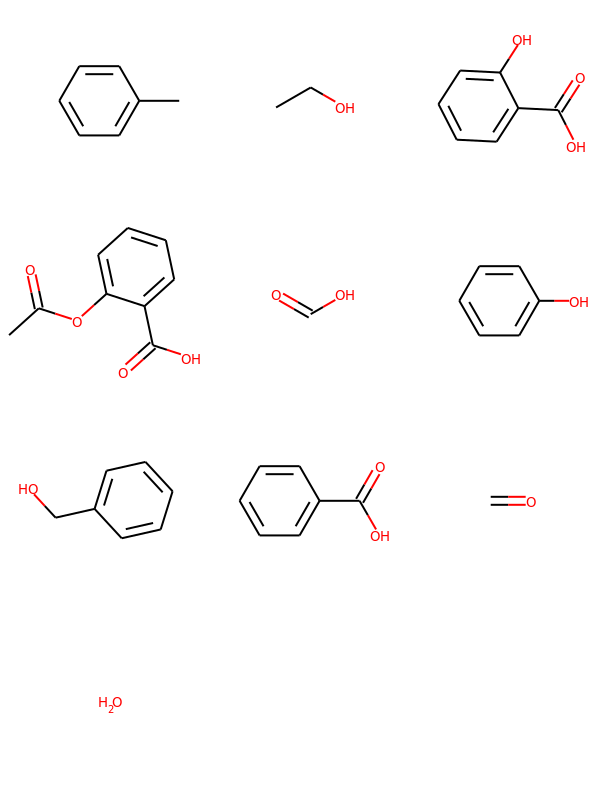

In [35]:
Draw.MolsToGridImage([m for idx, m in results_mols])

In [36]:
aspirin = Chem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')

In [37]:
aspirin.ToBinary()

b'\xef\xbe\xad\xde\x00\x00\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\r\x00\x00\x00\r\x00\x00\x00\x80\x01\x08\x00(\x00\x00\x00\x03\x02\x06\x00(\x00\x00\x00\x03\x04\x06\x00`\x00\x00\x00\x01\x03\x08\x00(\x00\x00\x00\x03\x02\x06@(\x00\x00\x00\x03\x04\x06@h\x00\x00\x00\x03\x03\x01\x06@h\x00\x00\x00\x03\x03\x01\x06@h\x00\x00\x00\x03\x03\x01\x06@h\x00\x00\x00\x03\x03\x01\x06@(\x00\x00\x00\x03\x04\x06\x00(\x00\x00\x00\x03\x04\x08\x00(\x00\x00\x00\x03\x02\x08\x00h\x00\x00\x00\x03\x01\x01\x0b\x00\x01(\x02\x01\x02\x00\x01\x03 \x03\x04 \x04\x05h\x0c\x05\x06h\x0c\x06\x07h\x0c\x07\x08h\x0c\x08\th\x0c\t\n \n\x0b(\x02\n\x0c \t\x04h\x0c\x14\x01\x06\x04\t\x08\x07\x06\x05\x17\x00\x00\x00\x00\x16'

In [40]:
c.rollback()
cursor.execute("select id, mol_to_pkl(rdmol) from drugbank.molecule where rdmol<@mol_from_pkl({})".format(
    pg.Binary(aspirin.ToBinary())))
results = cursor.fetchall()
results

[(7074, <memory at 0x7f54e14091c8>),
 (780, <memory at 0x7f54e1409108>),
 (817, <memory at 0x7f54e1409288>),
 (826, <memory at 0x7f54e1409348>),
 (1691, <memory at 0x7f54e1409408>),
 (2879, <memory at 0x7f54e14094c8>),
 (4668, <memory at 0x7f54e1409588>),
 (3359, <memory at 0x7f54e1409648>),
 (3406, <memory at 0x7f54e1409708>),
 (6865, <memory at 0x7f54e14097c8>)]

# Other tables 

In [44]:
for m in drugbank[:100]:
    try:
        print(m.GetProp('DRUG_GROUPS'))
    except KeyError:
            pass

approved; investigational
approved
approved
approved; investigational
approved; investigational; vet_approved
approved
approved; investigational
nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; investigational; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical; vet_approved
approved; nutraceutical
nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical; vet_approved
approved; nutraceutical
approved; nutraceutical
approved; nutraceutical
approved; nutr

In [45]:
for m in drugbank[:100]:
    try:
        print(m.GetProp('SYNONYMS'))
    except KeyError:
            pass

1-(3-mercaptopropionic acid)-8-D-arginine-vasopressin; 1-deamino-8-D-arginine vasopressin; 1-Desamino-8-D-arginine vasopressin; DDAVP; Desmopresina; Desmopressine; Desmopressinum
Cetrorelixum
Ciclosporin; Ciclosporina; Ciclosporine; Ciclosporinum; CsA; CyA; Cyclosporin; Cyclosporin A
2-(L-phenylalanine)-8-L-lysinevasopressin; Felipresina; Felypressin; Felypressine; Felypressinum; PLV-2
Octreotida; Octreotidum; Octrotide
3-hydroxy-2-methyl-5-((phosphonooxy)methyl)-4-pyridinecarboxaldehyde; 3-hydroxy-5-(hydroxymethyl)-2-methylisonicotinaldehyde 5-phosphate; Codecarboxylase; PLP; Pyridoxal 5-monophosphoric acid ester; Pyridoxal 5-phosphate; Pyridoxal 5'-phosphate; Pyridoxal P; Pyridoxal phosphate anhydrous; Pyridoxal-5P; Pyridoxal-P
Cyanocob(III)alamin; Vitamin B12; Vitamin B12 complex
5,6,7,8-tetrahydrofolate; 5,6,7,8-tetrahydrofolic acid; tetrahydrofolate
(S)-4-(2-Amino-2-carboxyethyl)imidazole; (S)-a-Amino-1H-imidazole-4-propanoic acid; (S)-alpha-Amino-1H-imidazole-4-propionic acid; (S

In [46]:
cursor.execute("select id, DRUGBANK_ID from drugbank.molecule limit 10")
cursor.fetchall()

[(2, 'DB00014'),
 (3, 'DB00035'),
 (4, 'DB00050'),
 (5, 'DB00091'),
 (16, 'DB00122'),
 (6, 'DB00093'),
 (7, 'DB00104'),
 (8, 'DB00114'),
 (9, 'DB00115'),
 (10, 'DB00116')]

In [48]:
cursor.execute("select id, DRUGBANK_ID from drugbank.molecule")
drugbank2dbid = {drugbank: idx for idx, drugbank in cursor.fetchall()}
drugbank2dbid

{'DB00014': 2,
 'DB00035': 3,
 'DB00050': 4,
 'DB00091': 5,
 'DB00122': 16,
 'DB00093': 6,
 'DB00104': 7,
 'DB00114': 8,
 'DB00115': 9,
 'DB00116': 10,
 'DB09316': 7010,
 'DB00117': 11,
 'DB00118': 12,
 'DB00119': 13,
 'DB00120': 14,
 'DB00121': 15,
 'DB00123': 17,
 'DB00125': 18,
 'DB00126': 19,
 'DB00127': 20,
 'DB00128': 21,
 'DB00129': 22,
 'DB00130': 23,
 'DB00131': 24,
 'DB00132': 25,
 'DB00133': 26,
 'DB00134': 27,
 'DB00135': 28,
 'DB00136': 29,
 'DB00137': 30,
 'DB00138': 31,
 'DB00139': 32,
 'DB01574': 1364,
 'DB00140': 33,
 'DB00143': 36,
 'DB00144': 37,
 'DB00145': 38,
 'DB00146': 39,
 'DB00147': 40,
 'DB00148': 41,
 'DB00149': 42,
 'DB00150': 43,
 'DB00151': 44,
 'DB00152': 45,
 'DB00161': 54,
 'DB00172': 64,
 'DB00153': 46,
 'DB00154': 47,
 'DB01576': 1365,
 'DB00155': 48,
 'DB00156': 49,
 'DB07650': 5511,
 'DB00157': 50,
 'DB00158': 51,
 'DB00159': 52,
 'DB00160': 53,
 'DB00162': 55,
 'DB00163': 56,
 'DB00165': 57,
 'DB00166': 58,
 'DB00167': 59,
 'DB00168': 60,
 'DB0016

In [67]:
def molecule2synonym(m):
    try:
        synonyms = [syn.strip().replace("'", "''") for syn in m.GetProp('SYNONYMS').split(";")]
    except KeyError:
        synonyms = []
    return synonyms

In [68]:
molecule2synonym(drugbank[666])

['Propantelina bromuro',
 'Propantelina, bromuro de',
 'Propanthelin bromid',
 'Propanthéline, bromure de',
 'Propanthelini Bromidum']

In [69]:
def molecule2synonym_insertstr(m, drugbank2dbid):
    dbid = drugbank2dbid[m.GetProp('DRUGBANK_ID')]
    return ",".join(["({}, '{}')".format(dbid, synonym) for synonym in molecule2synonym(m)])

In [70]:
molecule2synonym_insertstr(drugbank[666], drugbank2dbid)

"(667, 'Propantelina bromuro'),(667, 'Propantelina, bromuro de'),(667, 'Propanthelin bromid'),(667, 'Propanthéline, bromure de'),(667, 'Propanthelini Bromidum')"

In [73]:
query = "insert into drugbank.synonyms (molid, name) values {}".format(','.join([molecule2synonym_insertstr(m, drugbank2dbid) for m in drugbank
                                                                                if molecule2synonym_insertstr(m, drugbank2dbid)]))


In [77]:
c.rollback()
cursor.execute(query)

In [78]:
c.commit()

In [80]:
cursor.execute("select name, rdmol from drugbank.synonyms s join drugbank.molecule m on s.molid = m.id where name like '%salt%' limit 10")
cursor.fetchall()

[('7-Ethyl-2-methyl-4-undecanol sulfate sodium salt',
  'CCCCC(CC)CCC(CC(C)C)OS(=O)(=O)[O-].[Na+]'),
 ('7-ethyl-2-methyl-4-undecanolsulfate, sodium salt',
  'CCCCC(CC)CCC(CC(C)C)OS(=O)(=O)[O-].[Na+]'),
 ('3-Carboxy-2-hydroxy-N,N,N-trimethyl-1-propanaminium hydroxide, inner salt',
  'C[N+](C)(C)C[C@H](O)CC(=O)[O-]'),
 ("2-hydroxy-4,4'-stilbenedicarboxamidine bis(2-hydroxyethanesulphonate) (salt)",
  'N=C(N)c1ccc(C=Cc2ccc(C(=N)N)cc2O)cc1.O=S(=O)(O)CCO.O=S(=O)(O)CCO'),
 ('Carbonic acid monosodium salt', 'O=C([O-])O.[Na+]'),
 ('Nitric acid, gallium salt, anhydrate',
  'O=[N+]([O-])[O-].O=[N+]([O-])[O-].O=[N+]([O-])[O-].[Ga+3]'),
 ('Lactic acid ammonium salt', 'CC(O)C(=O)[O-].[NH4+]'),
 ('Cyanamide, calcium salt (1:1)', '[Ca+2].[N-]=C=[N-]'),
 ('methanediimine, calcium salt (1:1)', '[Ca+2].[N-]=C=[N-]'),
 ('2-hydroxy-1,2,3-propanetricarboxylic acid iron salt',
  'O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-].[Fe+3]')]

In [81]:
cursor.execute("select name, rdmol from drugbank.synonyms s join drugbank.molecule m on s.molid = m.id where name like '%acid%' limit 10")
cursor.fetchall()

[('1-(3-mercaptopropionic acid)-8-D-arginine-vasopressin',
  'N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CSSCCC(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(N)=O)C(=O)N1)C(=O)NCC(N)=O'),
 ('Pyridoxal 5-monophosphoric acid ester', 'Cc1ncc(COP(=O)(O)O)c(C=O)c1O'),
 ('5,6,7,8-tetrahydrofolic acid',
  'Nc1nc(=O)c2c([nH]1)NCC(CNc1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1)N2'),
 ('(S)-a-Amino-1H-imidazole-4-propanoic acid', 'N[C@@H](Cc1cnc[nH]1)C(=O)O'),
 ('(S)-alpha-Amino-1H-imidazole-4-propionic acid',
  'N[C@@H](Cc1cnc[nH]1)C(=O)O'),
 ('(S)-α-amino-1H-Imidazole-4-propanoic acid', 'N[C@@H](Cc1cnc[nH]1)C(=O)O'),
 ('2-ketopropionic acid', 'CC(=O)C(=O)O'),
 ('2-Oxopropanoic acid', 'CC(=O)C(=O)O'),
 ('a-Ketopropionic acid', 'CC(=O)C(=O)O'),
 ('Acetylformic acid', 'CC(=O)C(=O)O')]